## Análise e Classificação de Espectros de Supernovas

### Aluno: Luis Ricardo Arantes Filho - Doutorando CAP INPE
### CAP359 - Principles and Applications of Data Mining

### Introdução à Base de Espectros utilizada
Os espectros de luz das SNs foram obtidos no repositório aberto The Open Supernova Catalog [7], atualmente mantido por dois pesquisadores do Harvard-Smithsonian Center for Astrophysics (CfA). O acervo é uma coletânea dos dados de 17 bases de espectros mais contribuições individuais. Nele, estão disponíveis espectros de SNs dos tipos Ia, Ib, Ic, II e os tipos classificados apenas por fotometria. A Tabela 1 discrimina a quantidade de dados que foram obtidos para utilização no classificador.

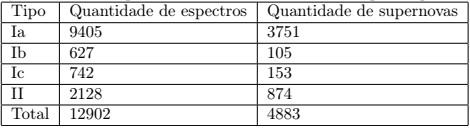

In [6]:
from IPython.display import Image
Image(filename="C:\/Users\/Administrador\/Documents\/Doutorado\/3_Periodo\/DataMining\/notebook_dataMining\/img\/tabela1.png",width = 600,height = 600)

### Descrição dos dados
Os dados deste acervo possuem uma distribuição não uniforme no sentido do número de exemplos de cada tipo de supernova. Os espectros de supernovas de tipo Ia possuem um numero superior às demais. 

### Disponibilização dos  dados Brutos
Os espectros contidos nas bases de dados possuem diversidade em relação a:

• quantidades de instrumentos de coleta de dados;

• variação nos comprimentos de onda dos espectros;

• variação das intensidades;

• variação em relação as fases das supernovas, compreendendo longos períodos de observação.


Os espectros da Tabela 1 são dispostos em arquivos no formato ascii com as colunas para o comprimento de onda em [Å] e o fluxo de radiação em [1e-15 erg/s/cm2/A]. A maioria dos espectros deste banco foram obtidos pelo telescópio FLWO 1.5m+FAST, com exceção da supernova SN 2003ch, a qual foi obtida pelos telescópios MMT 6.5m+Bluechannel e FLWO1.5m+FAST.

Muitas das informações encontram-se organizadas de maneiras diferentes, como arquivos texto, tabelas em formato pdf, csv e dados fits. Os atributos de valor de redshift e de fases espectrais também encontram-se nestes formatos, sendo dificil o acesso aos dados da base sem qualquer manipulação. As figuras 1 e 2, ilustram como as informações são dispostas.


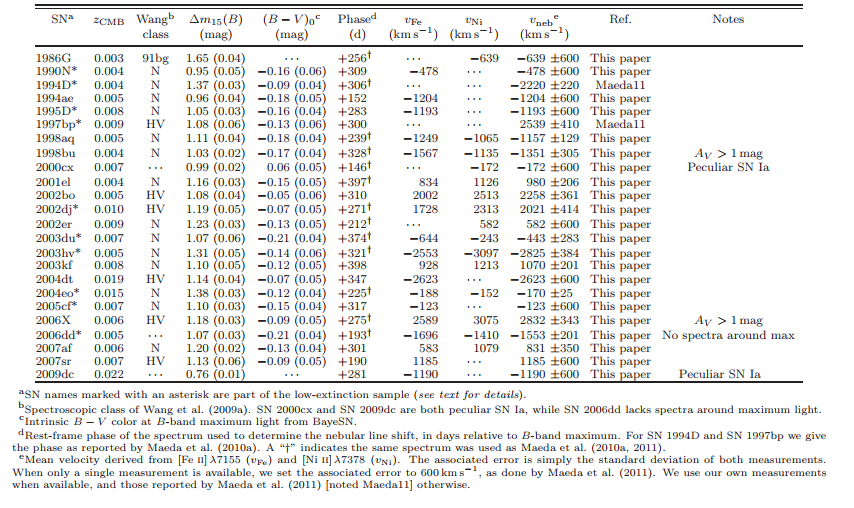

In [8]:
Image(filename="C:\/Users\/Administrador\/Documents\/Doutorado\/3_Periodo\/DataMining\/notebook_dataMining\/img\/pdf_data.png",width = 600,height = 600)

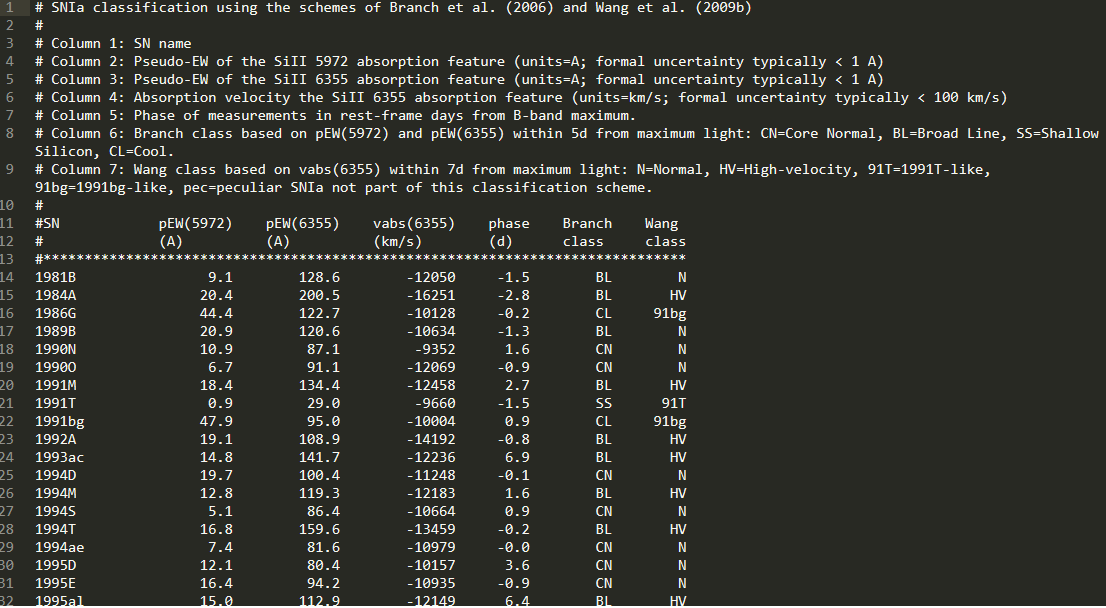

In [9]:
Image(filename="C:\/Users\/Administrador\/Documents\/Doutorado\/3_Periodo\/DataMining\/notebook_dataMining\/img\/pdf_data2.png",width = 600,height = 600)

## Manipulação dos dados para o formato de DataFrames

Para trabalhar melhor com as informações os dados foram transformados em DataFrames para agrupar todas as informaçoes relevantes das bases de dados. Desta forma, foram feitas reduções e ajustes para que não houvesse a falta de informações. Os dados inseridos no dataFrame possuem todas as informações de fase e de redshift, além do espectro completo (comprimento de onda x fluxo de radiação normalizado). Os dataFrames foram gerados de acordo com o notebook - Manipulando Dados Brutos de Supernovas.ipynb.

In [10]:
'''
IMPORTS
'''
import numpy as np
import matplotlib.pyplot as plt
'''
PROCESSAMENTO DE SINAIS
'''
from scipy.signal import savgol_filter
import scipy.integrate as integrate
import scipy.fftpack
from scipy.optimize import curve_fit
from scipy import optimize
from scipy.stats.distributions import  t
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
from scipy import interpolate
import scipy.stats as ss
'''
DATAFRAMES PANDAS
'''
import pandas as pd
from collections import OrderedDict

### Funções para Salvar e Acessar os dataFrames Gerados

In [11]:
def salvaDataFrames_csv(dataFrame,caminhoSaida,nomeArquivo):
    dataFrame.to_csv(caminhoSaida+'\/'+nomeArquivo, sep=',', encoding = 'utf-8')
       
def salvaDataFrames_pkl(dataFrame,caminhoSaida,nomeArquivo):
    dataFrame.to_pickle(caminhoSaida+'\/'+nomeArquivo, compression='infer')
    


caminhoDataframe = 'C:\/Users\/Administrador\/Documents\/Doutorado\/3_Periodo\/DataMining\/Dados\/' 

def abreDataFrame(caminho,nomeArq):
    dataFrame = pd.read_pickle(caminho + nomeArq)#READ PICKLE MUITO IMPORTANTE!!!!!
    return dataFrame

### DataFrame para Manipulação dos Espectros de Supernovas

In [12]:
dataFrame_SN = abreDataFrame(caminhoDataframe, 'dataFrame_thermo_Sem_Filtragem.pkl')
dataFrame_SN.head(10)

,Nome_Supernova,Tipo,Fase,Tag_Fase,SNx_Redshifted,SNy_Redshifted,Valor_Redshift
0,SN_Redshifted_sn1998V-19980319.flm,Ia,-1.890,Maximo,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.6103948484723085, 0.5980801867567795, 0.528...",0.0539
1,SN_Redshifted_sn1998V-19980320.flm,Ia,-1.890,Maximo,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.668855908329295, 0.5786985350911114, 0.6045...",0.0539
2,SN_Redshifted_sn1998V-19980321.flm,Ia,-0.956,Maximo,"[3657.8171091445433, 3661.546502254467, 3665.2...","[0.6505870738168444, 0.7070315887134473, 0.627...",0.0237
3,SN_Redshifted_sn1998dx-19980914.flm,Ia,-0.435,Maximo,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9960630979964985, 0.7975475132048128, 0.781...",0.0170
4,SN_Redshifted_sn1998dx-19980915.flm,Ia,-0.435,Maximo,"[3529.746655280387, 3533.3753907622395, 3537.0...","[1.0, 0.7604419442071815, 0.678694507215164, 0...",0.0170
5,SN_Redshifted_sn1998dx-19980917.flm,Ia,-0.435,Maximo,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.6322812330465324, 0.3556367714536715, 1.0, ...",0.0170
6,SN_Redshifted_sn1998dx-19980918.flm,Ia,-1.890,Maximo,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.6060208276014173, 0.6685512947606849, 0.455...",0.0539
7,SN_Redshifted_sn1998eg-19981024.flm,Ia,-1.890,Maximo,"[3633.8771124352834, 3637.5351614191113, 3641....","[0.6477901924667216, 0.7993760331142189, 0.695...",0.0539
8,SN_Redshifted_sn1999aa-19990223.flm,Ia,0.896,Maximo,"[3664.302600472813, 3668.0696654100907, 3671.8...","[0.6621820761920845, 0.6256435261635122, 0.572...",0.0152
9,SN_Redshifted_sn1999cc-19990516.flm,Ia,-1.891,Maximo,"[3606.048856145793, 3609.7560336606475, 3613.4...","[0.5048203499240077, 0.5561162196559927, 0.451...",0.0316


A análise evolutiva das explosões de supernovas Ia é destaque de diversos estudos que implicam em identificar, classificar e separar estas fontes de luminosidades para aplicações que lidam com os cálculos da expansão cósmica do universo. Supernovas Ia são explosões termonucleares geradas pelo colapso de estrelas anãs brancas, por ser um fenômeno causado por condições bem definidas, a análise da curva de luz e do espectro providenciam uma identificação homogênea do fenômeno. Avaliação espectral para identificar as supernovas Ia pode ser feita com acurácia quando o espectro atinge a luz máxima (fase espectral máxima = 0.0), este período tem uma variação de aproximadamente -2.5 a +2.5 dias em relação a luz máxima.

Este modelo buscou categorizar as fases em 10 periodos de evolução diferentes:

------ FASES INICIAIS E DE MÁXIMO -------

• -10 ~ -7 -- M1

• -7 ~ -3 -- M2

• -3 ~ +3 -- M3

• +3 ~ +7 -- M4

• +7 ~ +10 -- M5

As fases de M1 .. M5 são correspondentes às fases de máximos das Supernovas de tipo Ia que apresentam um padrão bem definido.

----- FASES PÓS MAXIMO E NEBULARES -------


• +10 ~ +15 -- P1

• +15 ~ +20 -- P2

• +20 ~ +25 -- P3

• +25 ~ +30 -- P4

• +30 ~ +35 -- P5

As fases de P1 .. P5 são correspondentes às fases nebulares das Supernovas de tipo Ia que são difíceis de observar e abstrair padrões.


Esta divisão reduziu muito da base de dados Original. A tabela 2 ilustra a nova base de dados com os espectros reduzidos.


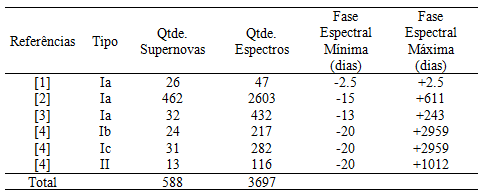

In [13]:
Image(filename="C:\/Users\/Administrador\/Documents\/Doutorado\/3_Periodo\/DataMining\/notebook_dataMining\/img\/tabela_dados.png",width = 600,height = 600)

## Gerando o Dataframe com as Reduções estabelecidas

In [14]:
'''
Normalizando os Espectros
'''
#limites dos espetros
lim_superior = 7000
lim_inferior = 4000

#Delimitador de Angstrons -- 3800 -- 7200
def delimitadorAngstrons(SNx,SNy):
    delSNx = []
    delSNy = []    
    for i in range(0,len(SNx)):
        if (SNx[i] >= lim_inferior and SNx[i]<=lim_superior):
            delSNx.append(SNx[i])
            delSNy.append(SNy[i])
    
    return delSNx,delSNy


#Interpola
##Interpolando os espectros
def interpola_8pontos(vetorx, vetory):
  x = vetorx
  y = vetory

  xnew = np.arange(np.min(x), np.max(x), 8)
  ynew = interp1d(x,y,kind='linear')
  
  return xnew,ynew(xnew)    


'''
GERA O DATAFRAME
'''
def gerandoDataFrameFases(dataFrame):
    data1 = dataFrame.loc[:,'SNx_Redshifted']
    data2 = dataFrame.loc[:,'SNy_Redshifted']
    data1 = data1.tolist()
    data2 = data2.tolist()
    
    novaListax =  []
    novaListay =  []

    for i in range(len(dataFrame.index)):
        dx,dy = delimitadorAngstrons(data1[i],data2[i])
        interx,intery = interpola_8pontos(dx,dy)
        novaListax.append(interx)
        novaListay.append(intery)
       
    
    data1 = novaListax  
    data2 = novaListay
    
    data7 = dataFrame.loc[:,'Nome_Supernova']
    data7 = data7.tolist()
    
    data8 = dataFrame.loc[:,'Tipo']
    data8 = data8.tolist()
    
    data9 = dataFrame.loc[:,'Fase']
    data9 = data9.tolist()
    
    '''
    gerando a separação
    '''
    lista = [] #generico para o nome de classes
    for i in range(len(dataFrame.index)):
        #lista
        '''
        FASES M - maximo
        FASES P - pós maximo - neb
        '''
        if(data9[i] >= -10 and data9[i] <= -7):
            lista.append('M1')
        elif(data9[i] > -7 and data9[i] <= -3):
            lista.append('M2')
        elif(data9[i] > -3 and data9[i] <= +3):
            lista.append('M3')
        elif(data9[i] > +3 and data9[i] <= +7):
            lista.append('M4')
        elif(data9[i] > +7 and data9[i] <= +10):
            lista.append('M5')
        elif(data9[i] > +10 and data9[i] <= +15):
            lista.append('P1')
        elif(data9[i] > +15 and data9[i] <= +20):
            lista.append('P2')
        elif(data9[i] > +20 and data9[i] <= +25):
            lista.append('P3')
        elif(data9[i] > +25 and data9[i] <= +30):
            lista.append('P4')
        elif(data9[i] > +30 and data9[i] <= +35):
            lista.append('P5')
        else:
            lista.append('No_class')
    
    data10 = dataFrame.loc[:,'Tag_Fase']
    data10 = data10.tolist()
    
    
    dataFrameFeatures = OrderedDict(
    {
     'Nome_SN':data7,
     'SNx_norm':data1,
     'SNy_norm':data2,
     'Fase':data9,
     'Tipo':data8,
     'Tag_Fase':data10,
     'Fase_Selecao': lista
     })
    df = pd.DataFrame(dataFrameFeatures)

    return df


dataFrame_Selecao_fases = gerandoDataFrameFases(dataFrame_SN)

dataFrame_Selecao_fases.head(10)

,Nome_SN,SNx_norm,SNy_norm,Fase,Tipo,Tag_Fase,Fase_Selecao
0,SN_Redshifted_sn1998V-19980319.flm,"[4000.0132876239077, 4008.0132876239077, 4016....","[0.7935526882817624, 0.8224037320882264, 0.836...",-1.890,Ia,Maximo,M3
1,SN_Redshifted_sn1998V-19980320.flm,"[4000.0132876239077, 4008.0132876239077, 4016....","[0.8124123078712547, 0.7798971253889206, 0.789...",-1.890,Ia,Maximo,M3
2,SN_Redshifted_sn1998V-19980321.flm,"[4000.921275257559, 4008.921275257559, 4016.92...","[0.8122789290326893, 0.808479578727523, 0.8249...",-0.956,Ia,Maximo,M3
3,SN_Redshifted_sn1998dx-19980914.flm,"[4001.482267921209, 4009.482267921209, 4017.48...","[0.638564199171519, 0.7355039088902157, 0.7049...",-0.435,Ia,Maximo,M3
4,SN_Redshifted_sn1998dx-19980915.flm,"[4001.482267921209, 4009.482267921209, 4017.48...","[0.5772353719680303, 0.544093190047079, 0.6076...",-0.435,Ia,Maximo,M3
5,SN_Redshifted_sn1998dx-19980917.flm,"[4001.482267921209, 4009.482267921209, 4017.48...","[0.5277520678956983, 0.5219502412669544, 0.705...",-0.435,Ia,Maximo,M3
6,SN_Redshifted_sn1998dx-19980918.flm,"[4001.482267921209, 4009.482267921209, 4017.48...","[0.6589231770879599, 0.7179617631532053, 0.739...",-1.890,Ia,Maximo,M3
7,SN_Redshifted_sn1998eg-19981024.flm,"[4003.3400598019134, 4011.3400598019134, 4019....","[0.7313347223332186, 0.7092240083638499, 0.707...",-1.890,Ia,Maximo,M3
8,SN_Redshifted_sn1999aa-19990223.flm,"[4003.3384448278066, 4011.3384448278066, 4019....","[0.8968872615980215, 0.906083787206773, 0.9344...",0.896,Ia,Maximo,M3
9,SN_Redshifted_sn1999cc-19990516.flm,"[4002.716850235268, 4010.716850235268, 4018.71...","[0.6507061983644398, 0.7342926757936842, 0.753...",-1.891,Ia,Maximo,M3


## Os Notebooks da sequência do estudo para a base de dados reduzida:
### 1º - Análise de Fases de Supernovas Ia; 
### 2º - Classificação de tipos Espectrais por Redes Neurais. 